In [1]:
import cv2
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import random
import time
import memory_profiler
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(device)

cuda


In [3]:
# from torchvision.datasets import VOCDetection
# #downLoad Pascal VOC dataset
# VOCDetection(root='VOC_data', year='2012', image_set='trainval', download=True)

In [4]:
VOC_CLASSES_original = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

In [5]:
# Define VOC_CLASSES for segmentation
VOC_CLASSES = {
    "bicycle": 2, "bus": 6, "car": 7, "motorbike": 14, "person": 15
}
# Re-index values
VOC_CLASSES_ReIndex = {name: idx+1 for idx, (name, _) in enumerate(VOC_CLASSES.items())}
print(VOC_CLASSES_ReIndex)

{'bicycle': 1, 'bus': 2, 'car': 3, 'motorbike': 4, 'person': 5}


In [6]:
class Config:
    learning_rate = 0.005 #0.005
    momentum = 0.9
    weight_decay = 0.0005
    iou_threshold = 0.5
    patience = 10
    classes = VOC_CLASSES_ReIndex

In [7]:
# Define the model. look trainable_backbone_layers = 3?
def get_model(num_classes):
    # Load a pre-trained Mask R-CNN model with a ResNet-50 backbone
    model = maskrcnn_resnet50_fpn(
                weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT,
                weights_backbone=ResNet50_Weights.DEFAULT,
                trainable_backbone_layers=3)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # FastRCNNPredictor

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # Mask R-CNN mask predictor hidden layer size (default is 256)
    # Replace the mask predictor with new number of classes
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


In [8]:
# Load the Mask R-CNN model
model = get_model(len(Config.classes)+1)
model = model.to(device)

In [9]:
# fine tunned classes
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=6, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
)

In [10]:
# fine tunned classes
model.roi_heads.mask_predictor

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
# transform original
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [12]:
# transform custom in model
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [13]:
class ResizeNormalizeTransform:
    def __init__(self, normalize=False, min_size=400, max_size=600, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

        self.normalize = normalize
        self.min_size = min_size
        self.max_size = max_size
        self.mean = mean
        self.std = std

    def __call__(self, image, boxes, masks=None):
        # Get original size
        original_width, original_height = image.size

        # Calculate scaling factor to maintain aspect ratio
        min_original_size = float(min(original_width, original_height))
        max_original_size = float(max(original_width, original_height))

        # Calculate scale factor
        scale = self.min_size / min_original_size

        # Check if the scaling would make the longer side too big
        if scale * max_original_size > self.max_size:
            scale = self.max_size / max_original_size

        # Calculate new size
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize image
        image = T.Resize((new_height, new_width))(image)

        # Adjust bounding boxes
        if boxes is not None and len(boxes):
            boxes = boxes.clone()
            boxes[:, [0, 2]] *= (new_width / original_width)  # Scale x coordinates
            boxes[:, [1, 3]] *= (new_height / original_height)  # Scale y coordinates

        # Adjust masks if provided
        if masks is not None and len(masks):
            masks = torch.nn.functional.interpolate(
                masks.unsqueeze(1).float(),
                size=(new_height, new_width),
                mode="nearest"
            ).squeeze(1)

        # Convert to tensor and normalize
        image = T.ToTensor()(image)
        if self.normalize:
            image = T.Normalize(mean=self.mean, std=self.std)(image)

        return image, boxes, masks

# Instance transformation
transform = ResizeNormalizeTransform()


In [14]:
# VOC_CLASSES_inverted
VOC_CLASSES_inverted = {v: k for k, v in VOC_CLASSES_ReIndex.items()}
print(VOC_CLASSES_inverted)

{1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorbike', 5: 'person'}


In [15]:
def plot_training_metrics(history):
    """Visualize training metrics"""
    fig = plt.figure(figsize=(22, 8))
    fig.suptitle('Training Metrics', fontsize=16)

    epochs = range(1, len(history['train_loss']) + 1)

    # Training Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # mAP Over Epochs
    plt.subplot(3, 2, 2)
    mAP_values = [metrics['overall']['mAP'] for metrics in history['val_metrics']]
    plt.plot(epochs, mAP_values)
    plt.title('Mean Average Precision')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # IoU Metrics
    plt.subplot(3, 2, 3)
    bbox_iou = [metrics['overall']['bbox_iou'] for metrics in history['val_metrics']]
    mask_iou = [metrics['overall']['mask_iou'] for metrics in history['val_metrics']]
    plt.plot(epochs, bbox_iou, label='Bbox IoU')
    plt.plot(epochs, mask_iou, label='Mask IoU')
    plt.title('Intersection over Union')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Precision, Recall, F1 Score
    plt.subplot(3, 2, 4)
    precision = [metrics['overall']['precision'] for metrics in history['val_metrics']]
    recall = [metrics['overall']['recall'] for metrics in history['val_metrics']]
    f1_score = [metrics['overall']['f1_score'] for metrics in history['val_metrics']]
    dice = [metrics['overall']['dice_coefficient'] for metrics in history['val_metrics']]
    plt.plot(epochs, precision, label='Precision')
    plt.plot(epochs, recall, label='Recall')
    plt.plot(epochs, f1_score, label='F1 Score')
    plt.plot(epochs, dice, label='Dice Coefficient')
    plt.title('Performance Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Per-class Performance
    plt.subplot(3, 2, 5)
    per_class_performance = [
        sum(metrics['per_class'][cls]['precision'] for cls in metrics['per_class']) / len(metrics['per_class'])
        for metrics in history['val_metrics']]
    plt.plot(epochs, per_class_performance)
    plt.title('Average Per-class Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Detection Performance
    plt.subplot(3, 2, 6)
    # Compute total tp, fp, fn for all classes at each epoch ##### revisar metrics['per_class'][cls]['tp'] for cls in metrics['per_class']
    total_tp_fp_fn_per_epoch = [
        {
            'tp': sum(metrics['per_class'][cls]['tp'] for cls in metrics['per_class']),
            'fp': sum(metrics['per_class'][cls]['fp'] for cls in metrics['per_class']),
            'fn': sum(metrics['per_class'][cls]['fn'] for cls in metrics['per_class'])
        }
        for metrics in history['val_metrics']]  # Iterate through epochs

    # Extract tp, fp, fn values for plotting
    tp_values = [epoch_metrics['tp'] for epoch_metrics in total_tp_fp_fn_per_epoch]
    fp_values = [epoch_metrics['fp'] for epoch_metrics in total_tp_fp_fn_per_epoch]
    fn_values = [epoch_metrics['fn'] for epoch_metrics in total_tp_fp_fn_per_epoch]

    plt.plot(epochs, tp_values, label='True Positives (TP)', marker='o')
    plt.plot(epochs, fp_values, label='False Positives (FP)', marker='s')
    plt.plot(epochs, fn_values, label='False Negatives (FN)', marker='^')

    plt.title('Detection Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Count')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
def plot_metrics_per_class(history_metrics):
    """
    Visualize mean metrics across validation results per class.
    """
    # Metrics to plot
    metrics_to_plot = [
        'precision', 'recall', 'f1_score',
        'bbox_iou', 'mask_iou', 'dice_coefficient'
    ]

    # compute
    mean_metrics = compute_mean_metrics(history_metrics)

    # Extract class names
    class_names = list(mean_metrics.keys())

    # Set up the figure for plotting
    fig, axs = plt.subplots(1, 6, figsize=(22, 5))  # 1 row, 6 columns
    fig.suptitle('Mean Instance Segmentation Metrics by Class')

    for i, metric in enumerate(metrics_to_plot):
        # Extract mean values for the current metric
        class_values = [mean_metrics[class_name][metric] for class_name in class_names]

        # Create bar plot
        axs[i].bar(class_names, class_values, color='skyblue')
        axs[i].set_title(metric.replace('_', ' ').title())

        # Rotate x-axis labels for readability
        axs[i].set_xticks(range(len(class_names)))
        axs[i].set_xticklabels(class_names, rotation=45)

    plt.tight_layout()
    plt.show()


In [17]:
def compute_mean_metrics(val_metrics):
    """
    Compute the mean of metrics for each class across validation results.
    """
    # Initialize a dictionary to store cumulative sums
    metric_sums = {}
    num_entries = len(val_metrics)

    for entry in val_metrics:
        per_class = entry['per_class']
        for class_name, metrics in per_class.items():
            if class_name not in metric_sums:
                # Initialize the dictionary for the class with zero values
                metric_sums[class_name] = {metric: 0.0 for metric in metrics.keys()}

            # Add the metrics to the cumulative sums
            for metric, value in metrics.items():
                metric_sums[class_name][metric] += value

    # Compute the averages
    mean_metrics = {}
    for class_name, metrics in metric_sums.items():
        mean_metrics[class_name] = {metric: value / num_entries for metric, value in metrics.items()}

    return mean_metrics

In [18]:
# Prepare optimizer and scheduler
params = [param for name, param in model.named_parameters() if param.requires_grad]
optimizer = torch.optim.SGD(params, lr=Config.learning_rate, momentum=Config.momentum, weight_decay=Config.weight_decay)
#optimizer = torch.optim.Adam(params, lr=Config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
#scheduler = get_lr_scheduler(optimizer, Config.num_epochs)
# cosine annealing scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)


In [19]:
# Function to load the best model
def load_best_model(model, optimizer, load_path):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch']
        history = checkpoint['metrics']
        return model, epoch, history
    else:
        print("No saved model found.")
        return model, optimizer, 0.0, -1

### Inference

In [20]:
# load the best model:
load_path='checkpoints/maskRCNN/model_epoch_25_maskRCNN_V0.pth'
model, epoch, history = load_best_model(model, optimizer, load_path=load_path)
model = model.to(device)

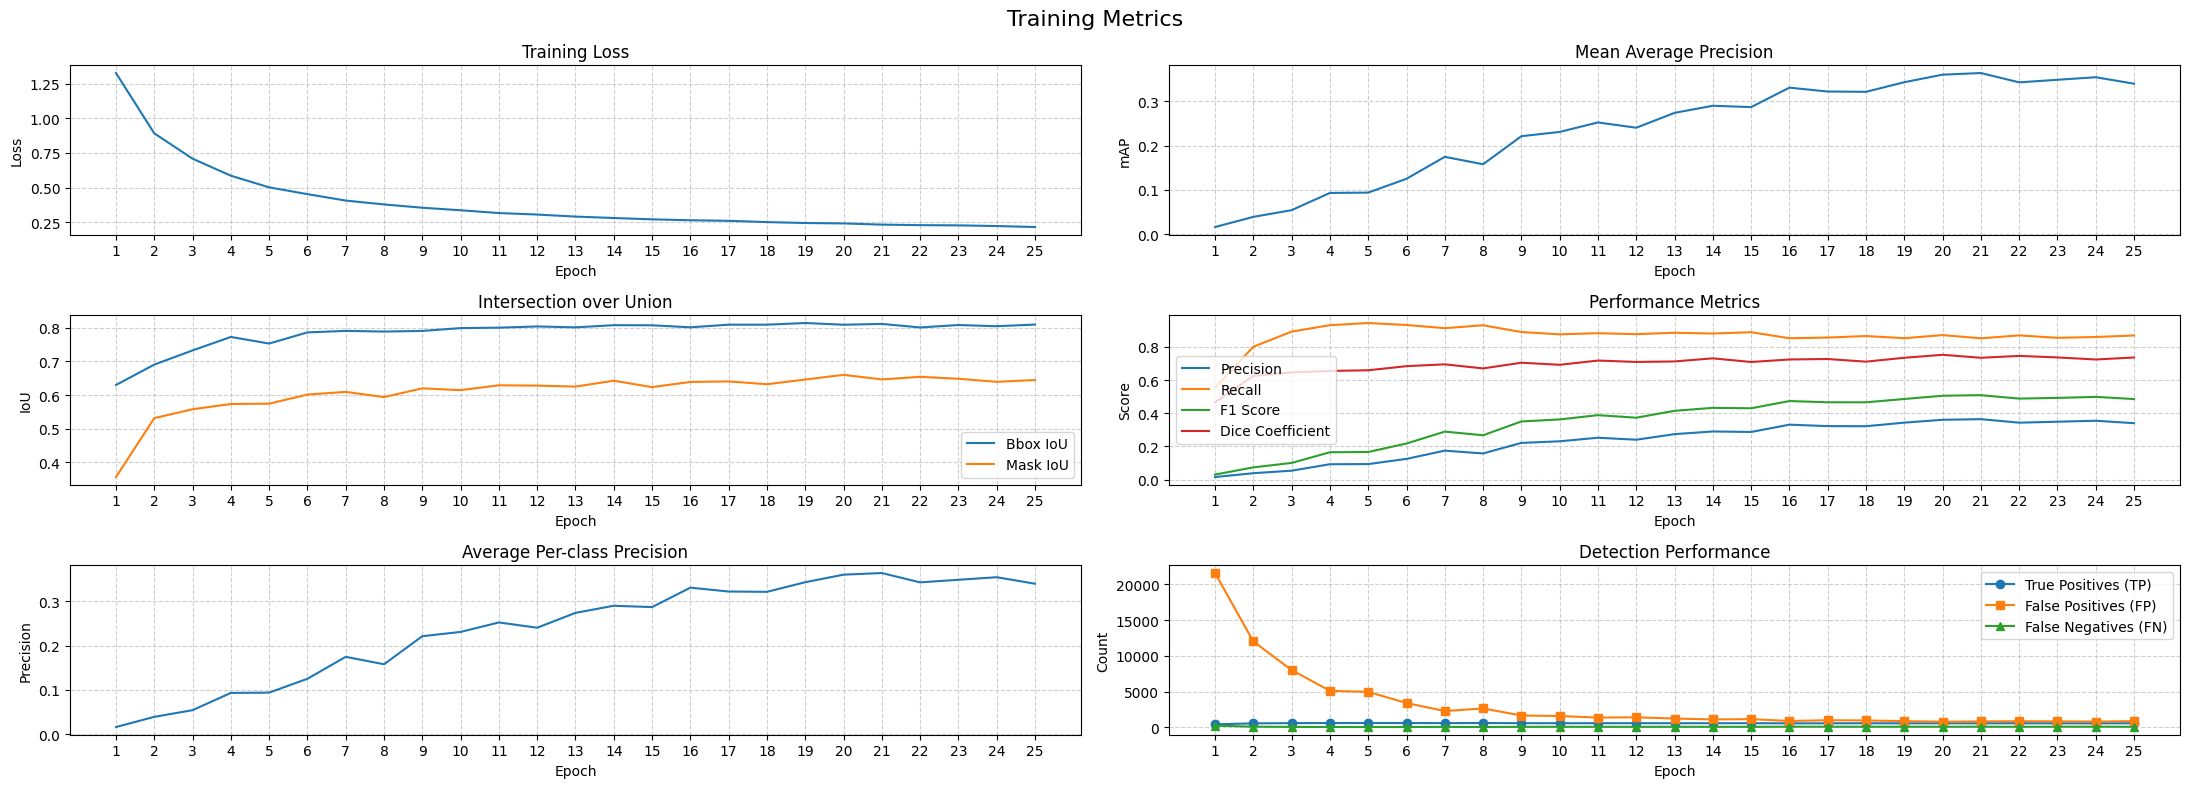

In [21]:
# Load history from checkpoint
plot_training_metrics(history)

In [22]:
# Get best mAP value
best_map = max([x['overall']['mAP'] for x in history['val_metrics']])

# Get epoch with best mAP
best_epoch = np.argmax([x['overall']['mAP'] for x in history['val_metrics']])

# Print best results
print(f"Best mAP: {best_map:.4f} at epoch {best_epoch+1}")
print(f"Corresponding Precision: {history['val_metrics'][best_epoch]['overall']['precision']:.4f}")
print(f"Corresponding Recall: {history['val_metrics'][best_epoch]['overall']['recall']:.4f}")

Best mAP: 0.3643 at epoch 21
Corresponding Precision: 0.3643
Corresponding Recall: 0.8516


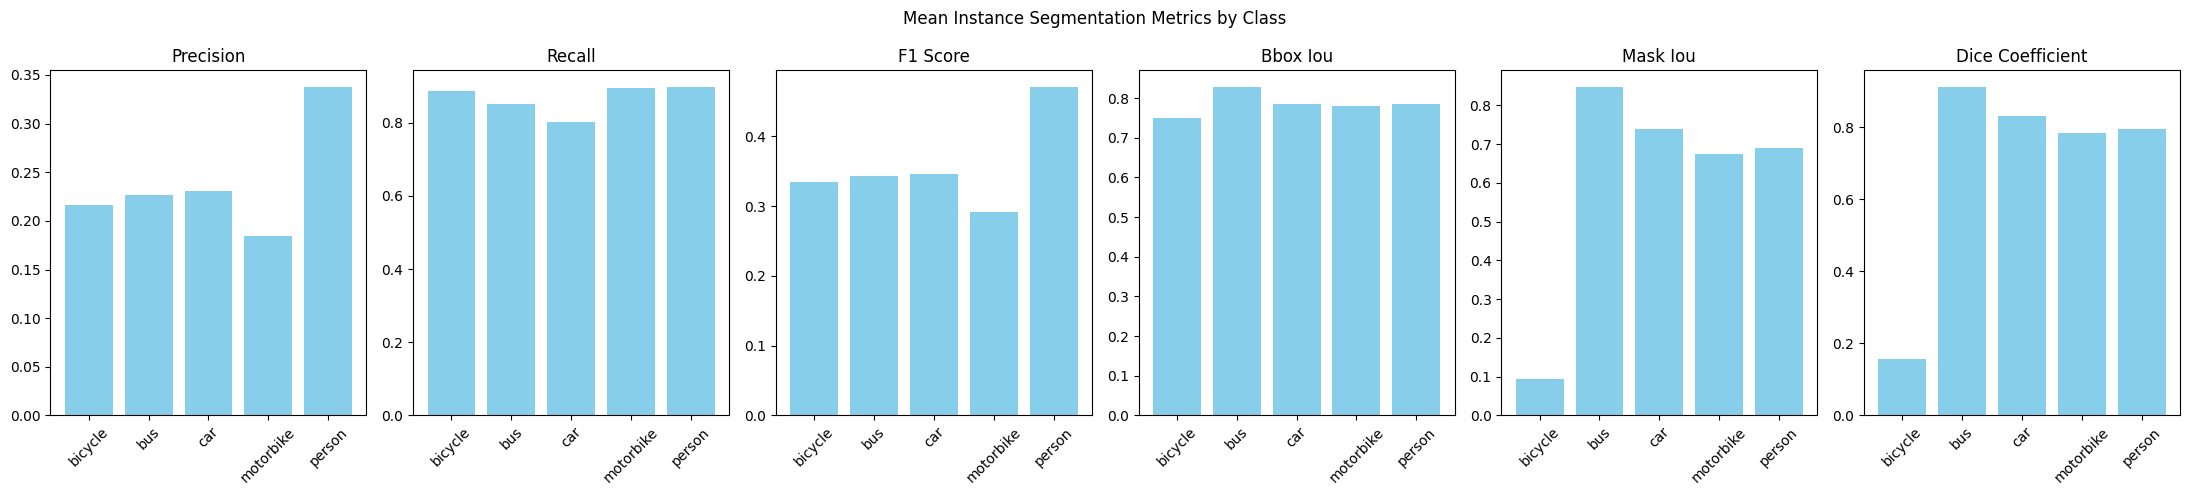

In [23]:
# plot mean metrics per class
plot_metrics_per_class(history['val_metrics'])

In [24]:
# prediction function
def predict_image(model, image, device, confidence_threshold=0.5):

    model.eval()

    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    transform.normalize = True
    
    image, _, _ = transform(image, None, None)

    # Prepare image for model
    image = image.to(device)

    with torch.no_grad():
        predictions = model([image])

    boxes = predictions[0]['boxes'].cpu()
    labels = predictions[0]['labels'].cpu()
    scores = predictions[0]['scores'].cpu()
    masks = predictions[0]['masks'].cpu()

    # Filter by confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    masks = masks[mask]

    return image, boxes, labels, scores, masks

In [25]:
def visualize_predictions_with_masks(image, boxes, labels, scores, masks, VOC_CLASSES):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # 
    img = image.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)

    # Show original image with boxes
    ax1.imshow(img)

    # Create colored mask overlay
    mask_overlay = np.zeros_like(img)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(masks)))[:, :3]

    for box, label, score, mask, color in zip(boxes, labels, scores, masks, colors):
        mask = mask.squeeze().numpy()
        mask_overlay[mask > 0.5] = color * 255

        # Draw box
        box = box.numpy().astype(int)
        rect = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax1.add_patch(rect)

        # Add label
        class_name = VOC_CLASSES_inverted.get(label.item(), "Unknown")
        ax1.text(box[0], box[1]-5, f'{class_name}: {score:.2f}',
                color='white', bbox=dict(facecolor=color))

    # Show mask overlay
    ax2.imshow(img)
    ax2.imshow(mask_overlay, alpha=0.5)

    ax1.set_title('Detections')
    ax2.set_title('Instance Segmentation')
    plt.show()

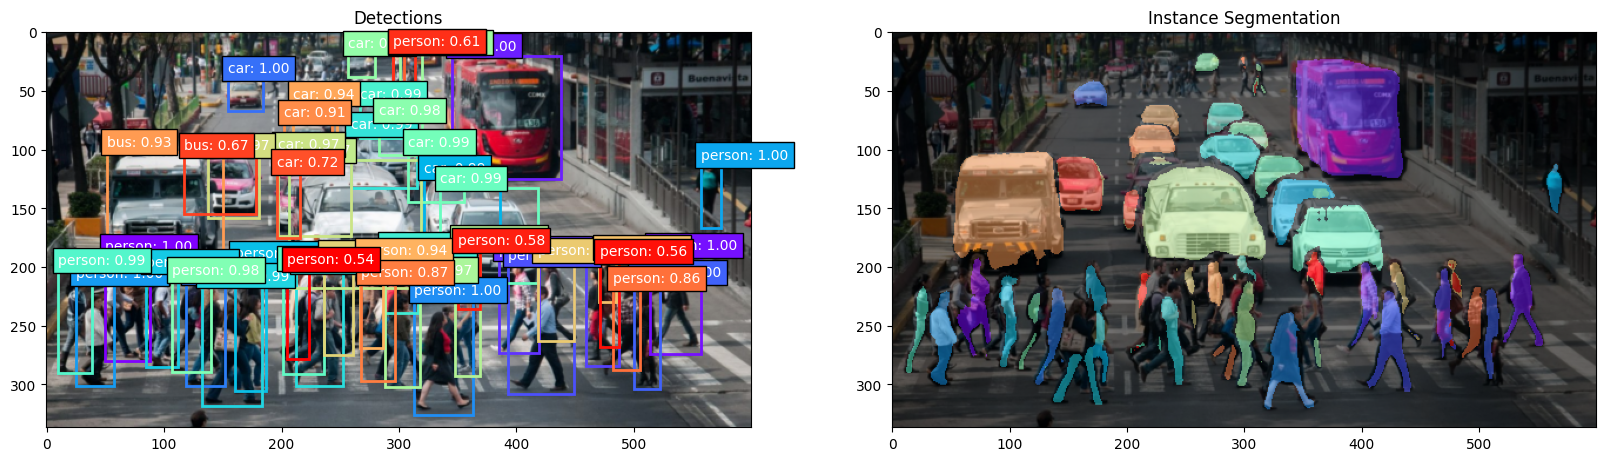

In [26]:
file = 'img.jpg'
image, boxes, labels, scores, masks = predict_image(model, file, device, confidence_threshold=0.5)
visualize_predictions_with_masks(image, boxes, labels, scores, masks, VOC_CLASSES_ReIndex)

In [50]:
def process_video(model, video_path, output_path, output_path_overlay, class_names, device, 
                  confidence_threshold=0.5, fps=6, frame_skip=4, output_size=(600, 400)):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return

    # Create video writer with resized dimensions
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, output_size)
    out_overlay = cv2.VideoWriter(output_path_overlay, fourcc, fps, output_size)

    # Counter for frame skipping
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        # Process every `frame_skip` frames
        if frame_count % frame_skip == 0:
            # Resize frame
            frame = cv2.resize(frame, output_size)

            # Convert BGR to RGB for PIL processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image
            image = Image.fromarray(frame_rgb)

            # Get predictions from model
            _, boxes, labels, scores, masks = predict_image(
                            model, image, device, confidence_threshold)

            # Create a mask overlay for visualization
            mask_overlay = np.zeros_like(frame, dtype=np.uint8)
            colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))[:, :3] * 255

            for box, label, score, mask, color in zip(boxes, labels, scores, masks, colors):
                # Ensure correct label name
                class_name = class_names.get(label.item(), "Unknown")

                # Process mask
                mask = mask.squeeze().detach().cpu().numpy()
                mask_overlay[mask > 0.5] = color

                # Draw bounding boxes and add labels
                box = box.detach().cpu().numpy().astype(int)
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                label_text = f"{class_name}: {score:.2f}"
                cv2.putText(frame, label_text, (box[0], box[1] - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Blend mask overlay with the original frame
            combined_frame = cv2.addWeighted(frame, 0.7, mask_overlay, 0.3, 0)

            # Write the frame to the output video
            out.write(combined_frame)
            out_overlay.write(mask_overlay)

            # Show the processed frame (optional)
            cv2.imshow('Processed Frame1', combined_frame)
            cv2.imshow('Processed Frame2', mask_overlay)

            # Press 'q' to quit early
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        frame_count += 1

    # Cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [51]:
# Video processing
process_video(model, 'input.mp4', 'output_maskRCNN.mp4', 'output_maskRCNN_overlay.mp4', 
              VOC_CLASSES_inverted, device, confidence_threshold=0.6)

Error: Could not read frame.


In [29]:
# Video processing
#process_video(model, 0, 'output_web.mp4', VOC_CLASSES, device)

In [30]:
def batch_inference(model, image_folder, output_folder, class_names, device, 
                   confidence_threshold=0.5):
    """
    Process all images in a folder
    """
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Load image
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert('RGB')
        
        # Get predictions
        boxes, labels, scores = predict_image(model, image, device, confidence_threshold)
        
        # Visualize and save
        output_path = os.path.join(output_folder, f'pred_{image_file}')
        visualize_predictions(image, boxes, labels, scores, class_names, output_path)


In [31]:
"""

# Additional utility functions
def get_color_map(num_classes):
    """Generate different colors for different classes"""
    colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
    return colors

def create_results_table(boxes, labels, scores, class_names):
    """Create a pandas DataFrame with detection results"""
    results = []
    for box, label, score in zip(boxes, labels, scores):
        results.append({
            'class': class_names[label - 1],
            'confidence': f"{score:.3f}",
            'bbox': f"[{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]"
        })
    return pd.DataFrame(results)

def save_results(boxes, labels, scores, class_names, output_path):
    """Save detection results to CSV"""
    df = create_results_table(boxes, labels, scores, class_names)
    df.to_csv(output_path, index=False)

"""

SyntaxError: invalid syntax (2142799420.py, line 5)